In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

%matplotlib inline

from mtspec import mtspecgram, multitaper_psd, ar_simulate
from aeps import AEP_metrics_lims
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split
from sklearn import decomposition

import pandas as pd

np.set_printoptions(suppress=True)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

In [14]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
session = sessions[-1]
session

'009266_hippoSIT_2023-06-19_08-58-35'

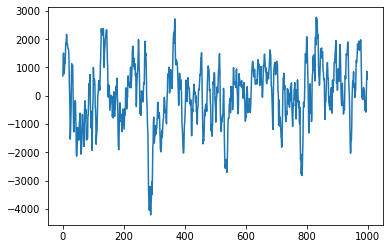

In [15]:
scr_path = "/home/sobolev/nevermind/Andrey/data/processed/"
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
rep_path = '/home/sobolev/nevermind/Andrey/analysis/reporting'

animal    = session.split('_')[0]
meta_file = os.path.join(dst_path, animal, session, 'meta.h5')
lfp_file  = os.path.join(dst_path, animal, session, 'lfp.h5')
aeps_file = os.path.join(dst_path, animal, session, 'AEPs.h5')
unit_file = os.path.join(dst_path, animal, session, 'units.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    tgt_mx       = np.array(f['processed']['target_matrix'])
    tl           = np.array(f['processed']['timeline'])
    trials       = np.array(f['processed']['trial_idxs'])
    
area = 'A1'
with h5py.File(aeps_file, 'r') as f:
    name = [x for x in f[area]][0]
    ch_no = int(name.split('_')[1])

single_units, spike_times = {}, {}
with h5py.File(unit_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(unit_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])
        
with h5py.File(lfp_file, 'r') as f:
    lfp = np.array(f['lfp'][:, ch_no])
    
plt.plot(lfp[:1000])

In [5]:
yspec, freq, time = mtspecgram(lfp, window_size=1000, window_step=100, fs=1000, NW=2, detrend=False)
yspec = yspec[0]

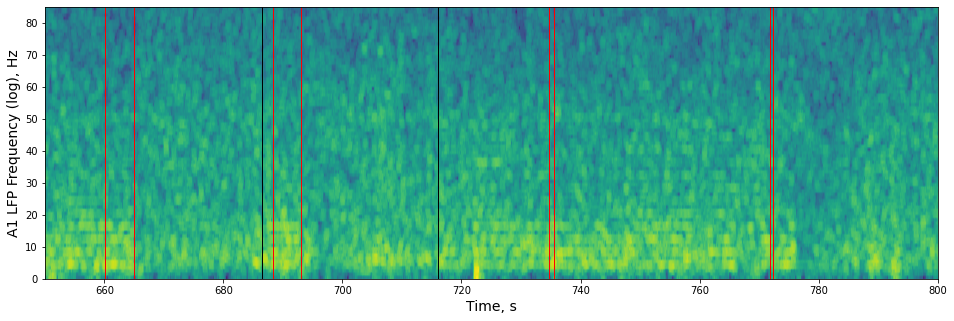

In [18]:
f_vals = [0, 85]
t_vals = [650, 800]

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.imshow(np.log(yspec[f_vals[0]:f_vals[1], t_vals[0]*10:t_vals[1]*10]), origin='lower', aspect='auto', extent=t_vals + f_vals)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('A1 LFP Frequency (log), Hz', fontsize=14)
ax.vlines(tl[tgt_mx[:, 2].astype(np.int32)][:, 0], f_vals[0], f_vals[1], color='red', lw=1)
ax.vlines(tl[tgt_mx[:, 3].astype(np.int32)][:, 0], f_vals[0], f_vals[1], color='red', lw=1)
ax.vlines(tl[trials[:, 0].astype(np.int32)][:, 0], f_vals[0], f_vals[1], color='black', lw=1)
ax.set_xlim(t_vals[0], t_vals[1])

# unit
#ax.plot(tl[:, 0], single_units[sel_unit]*0.4)
#fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_spectrogram_%d_%d.png' % (session[-19:-9], t_vals[0], t_vals[1])), dpi=1000)

## GLM on attention PPC / A1 pop SR / LFP signal power

(0.24119351832594638, 2.624074028872964e-107)

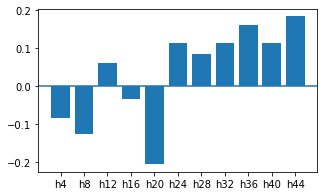

In [19]:
# ---- build prediction matrix -----

# take A1 OR PPC signal?

# take BGR only or BOTH BGR / TGT?
idxs_bgr = np.where(tl[::10][:, 6] == 1)[0][:-10]
#idxs_bgr = np.where((tl[::10][:, 6] == 1) | (tl[::10][:, 6] == 2))[0][:-10]

# 10 harmonics
harm_count = 11
harmonics = 4 * (np.arange(harm_count) + 1)
lfp_sig_mx = np.zeros([len(idxs_bgr), harm_count])
for i, harmonic_fr in enumerate(harmonics):
    lfp_sig_mx[:, i] = stats.zscore(yspec[harmonic_fr - 1:harmonic_fr + 2].mean(axis=0)[idxs_bgr])

# speed
speed = tl[:, 3][::10][idxs_bgr]

# reduce to either PPC AL, or 
#unit_act  = single_units['3-15'][::10][idxs_bgr]

# to pop SR dynamics
unit_names = [name for name in single_units.keys() if int(name[0]) < 3]  # take A1 only
unit_mx = np.zeros([len(tl), len(unit_names)])
for i, unit_id in enumerate(unit_names):
    unit_mx[:, i] = stats.zscore(single_units[unit_id])

pca = decomposition.PCA(n_components=3)
pca.fit(unit_mx)
X = pca.transform(unit_mx)

# ------------- build train / test datasets ---------

#y_fit = unit_act
y_fit = X[:, 0][::10][idxs_bgr] 

#dataset = np.column_stack([lfp_sig_mx, speed])
dataset = lfp_sig_mx

X_train, X_test, y_train, y_test = train_test_split(dataset, y_fit, test_size=0.6)

data = np.column_stack([y_train, X_train])
columns = ['state'] + ["h%d" % x for x in harmonics] #+ ['speed']
AM_df = pd.DataFrame(data, columns=columns)

# ------ GLM -------

model = glm('state ~ ' + ' + '.join(columns[1:]), data=AM_df).fit()
#model.summary()

# ------- test how good --------

glm_coeffs = dict([(i, coef) for i, coef in enumerate(model.params[1:]) if model.pvalues[1:][i] < 0.999])
target_fit = np.zeros(len(y_test))
for idx, coef in glm_coeffs.items():
    target_fit += coef * X_test[:, idx]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.bar(np.arange(len(glm_coeffs)), glm_coeffs.values())
ax.axhline(0)
ax.set_xticks(np.arange(len(glm_coeffs)))
_ = ax.set_xticklabels(columns[1:])

corr, pval = stats.pearsonr(target_fit, y_test)
corr, pval

## PSD

In [195]:
# freq = 10
# fs = 1000
# T = 5
# y = ar_simulate(freq, fs, T, r=.95, noise_std=.1, random_seed=42)

In [196]:
#mtspec, f = multitaper_psd(lfp[:50000], NW=2, fs=1000, K_max=10, detrend=False)
#plt.plot(mtspec[:200])

In [197]:
# Q:
# 1. How to compute PSD? Fails with error
# 2. How to correctly compute spectrogram: first bandpass filter and the spec or first spec and then select?
# 3. How to do whitening?
# 4. How to remove outliers to see better spectrogram?
# 5. Is 500ms a good window for spec?

In [198]:
# take BGR only!!
# idxs_bgr = np.where(tl[::10][:, 6] == 1)[0][:-20]

# lfp_sig  = yspec[3:20].mean(axis=0)[idxs_bgr]
# unit_act  = single_units[sel_unit][::10][idxs_bgr]
# speed     = tl[:, 3][::10][idxs_bgr]

# corr_pop, pval_p = stats.pearsonr(lfp_sig, unit_act)
# corr_speed, pval_s = stats.pearsonr(speed, unit_act)
# print("AL/gamma: %.2f (%.5f); Speed: %.2f (%.5f)" % (corr_pop, pval_p, corr_speed, pval_s))